# Mintervention Aware Optimization

This notebook demonstrates Python algorithms for optimal control constrained by keepout sets. We compare barrier methods to the new Mintervention-aware optimization

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy.linalg as LA
%matplotlib inline

# David McPherson's personal colors for plotting:
# Rows sorted by LAB L-value : 50, 20, 70
# Columns sorted by color : Rust, Turquoise, Sand, Indigo, Teal, Spring, Flesh, Magenta, Gray
colors = [['#cf4c34','#078752','#6333ed','#d6ca54','#0ca0ad','#2ea62a','#c96b0d','#d947bb','#777777'],
          ['#4C1C13','#073824','#2E186E','#575122','#065057','#164F14','#000000','#000000','#4D4D4D'],
          ['#FF745A','#0BD480','#9A7DF0','#FFF59C','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#ABABAB']]

plt.rcParams['font.sans-serif'] = "Gill Sans"
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "Georgia"
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 100

In [4]:
# Import custom libraries
import dlqr
import dynamics as dyn

In [5]:
# Simplify plots
def muteAxes(ax,xrange,yrange):
    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set ticks
    ax.xaxis.set_ticks(xrange)
    ax.yaxis.set_ticks(yrange)

    ax.tick_params(direction='in')
    for xb in xrange:
        for yb in yrange:
            rect = mplt.patches.Rectangle((xb+0.05,yb+0.05),0.9,0.9,color='#EEEEEE')
            ax.add_patch(rect)
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='x', colors='#777777')
    ax.yaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')

# Define the Dynamics to be used
The dynamics functions are accessed through an extension of the dynamics abstract base class (DynamicsABC) that provides handles to the flow and its (partial) derivatives.

In [6]:
# Double integrator dynamics
class InvertedPendulum(dyn.DynamicsABC):

    """
    Encodes double integrator dynamics

    Operates on a two-dimensional state space (z) with numbered states encoding:

      1. Angular position (w)
      2. Angular velocity (v)

    with the form:

    dw/dt = v
    dv/dt = u_0 + 1*sin(w)
    """

    def f(self,state,control):
        """Dynamic drift function of state over time

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            derivative (np.array): the time derivative of state over time according to these dynamics
        """
        Az = np.array([state[1],1*np.sin(state[0])])
        Bu = np.array([0,control[0]])
        derivative = Az + Bu
        return(derivative)

    def deriv_x(self,state,control):
        """Derivative of dynamics with respect to state

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            A (np.array): partial derivative of dynamics with respect to state
        """
        A = np.zeros((2,2))
        A[0,1] = 1
        A[1,0] = 1*np.cos(state[0])
        return(A)

    def deriv_u(self,state,control):
        """Derivative of dynamics with respect to control

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            B (np.array): partial derivative of dynamics with respect to state
        """
        B = np.array([[0],[1]])
        return(B)

    def __init__(self):
        super(InvertedPendulum,self).__init__(2,1)

In [7]:
vehicle = InvertedPendulum()
timestep_length = 0.01

## Load the Barriers and test them

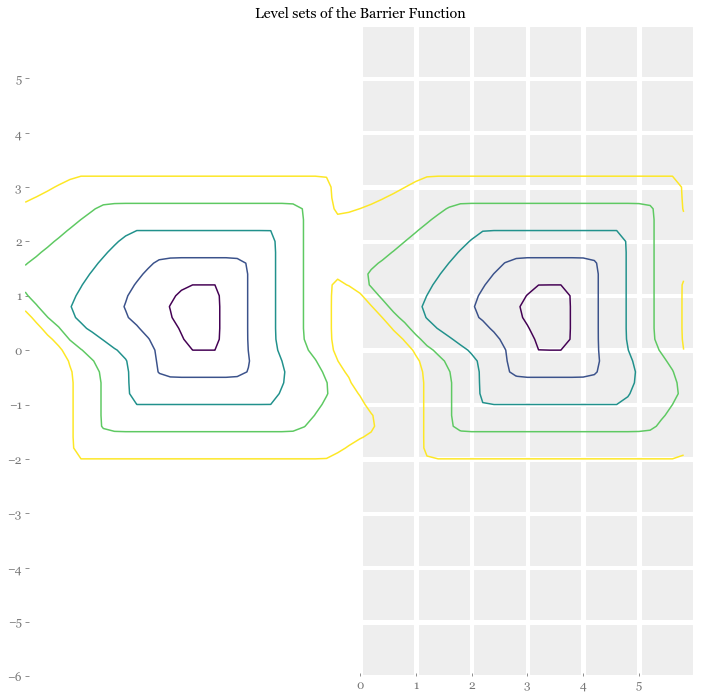

In [8]:
# Load the Safe Sets
import level_sets
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsStill_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum7Tenths_reachset.json")
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum4Ninths_reachset.json")

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(0,6),range(-6,6))

# Plot the safe set
delta = 0.2
x = np.arange(-6.0, 6.0, delta)
y = np.arange(-6.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
z = np.array([safeLevel.value([ex,ey]) for ex,ey in zip(X.flatten(),Y.flatten())])
Z = z.reshape(X.shape)
CS = plt.contour(X, Y, Z, [0,0.5,1,1.5,2])

# Plot the gradient of the levels (the direction the controller will choose to go)
#u = np.array([safeLevel.gradient([ex,ey])[0] for ex,ey in zip(X.flatten(),Y.flatten())])
#U = u.reshape(X.shape)
#v = np.array([safeLevel.gradient([ex,ey])[1] for ex,ey in zip(X.flatten(),Y.flatten())])
#V = v.reshape(X.shape)
#plt.quiver(X,Y, U,V)

plt.title('Level sets of the Barrier Function')
plt.show()

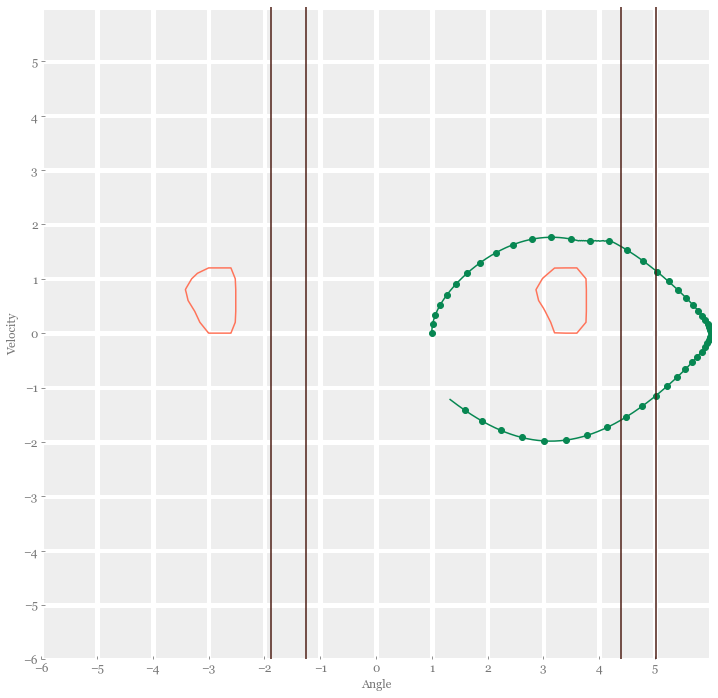

In [9]:
# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

# Test the safe set with controls that drive straight into the obstacle
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Forward simulate the dynamics with zero control
N = 1000
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))
states_init[:,0] = np.array([1,0])
for i in np.arange(0,N):
    control_init[:,i] = np.zeros((safe_vehicle.dimU,))
    states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])

# Plot the safe set intervention behavior on a mindless controller
CS = plt.contour(X, Y, Z, [0], colors = [colors[2][0]])
plt.xlabel("Angle")
plt.ylabel("Velocity")

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

obsAngTick = 7
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

In [10]:
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)

## Set the Agent's goals

In [12]:
# Define the Agent's objective function
import objective_functions as of
import quadratic_objectives as qof
import avoidance_objective as caof

# Define the custom angle-wrapping objective
class WrappedFirstState(of.RunningCostABC):
    """
    Wraps around a cost function but pre-processes its state to wrap the value in the interval
    [wraplowend, wraplowend+wraplength]
    Assumes 
    """
    def __init__(self,cost0,wraplength,wraplowend):
        self.cost0 = cost0
        self.wraplength = wraplength
        self.wraplowend = wraplowend
        super(WrappedFirstState,self).__init__()
        
    def wrap(self,state):
        wrapped_state = np.copy(state)
        wrapped_state[0] = (state[0] - self.wraplowend) % self.wraplength + self.wraplowend
        return(wrapped_state)

    def f(self,state,control,timestep):
        """Running cost for optimal control problem

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)
        """
        return(self.cost0.f(self.wrap(state),control,timestep) )

    def deriv_statestate(self,state,control,timestep):
        """Second derivative of running cost with respect to state

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)

        Returns:
            Hessian (np.matrix): second derivative with dimension z by z, where z is the dimension of the state
                vector

        This method is used to produce a second-order Taylor approximation of the cost around a guess trajectory.
        """
        return(self.cost0.deriv_statestate(self.wrap(state),control,timestep))

    def deriv_state(self,state,control,timestep):
        """First derivative of running cost with respect to state

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)
        """
        return(self.cost0.deriv_state(self.wrap(state),control,timestep))

    def deriv_controlcontrol(self,state,control,timestep):
        """Second derivative of running cost with respect to exogenous (control) input

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)

        Returns:
            Hessian (np.matrix): second derivative with dimension z by z, where z is the dimension of the control
                vector

        This method is used to produce a second-order Taylor approximation of the cost around a guess trajectory.

        """
        return(self.cost0.deriv_controlcontrol(self.wrap(state),control,timestep))

    def deriv_control(self,state,control,timestep):
        """First derivative of running cost with respect to exogenous (control) input

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)
        """
        return(self.cost0.deriv_control(self.wrap(state),control,timestep))


In [13]:
runningControlCost = qof.QuadraticControlCost(dlqr.QuadraticForm(vehicle.dimU,np.diag([0.05]),np.zeros((vehicle.dimU,1)),0))

Qprox = np.diag([1,1])
goal_state = np.array([0,0])
terminalCost = of.TerminalCost(
    WrappedFirstState(
    qof.QuadraticStateCost(
        dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                           -2*Qprox*np.matrix(goal_state).T,
                           np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
        )
    ,2*np.pi,-np.pi)
    * 80)

Agent_objective = runningControlCost*1

## Optimize trajectory with iLQR

In [14]:
import ilqr

mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                            timestep_length,
                                                                            safe_vehicle,
                                                                            Agent_objective,
                                                                            terminal_cost = terminalCost * (1/timestep_length),
                                                                            neverRetreat=True,ITER_NUM=15)

Initialization's cost is  260.3330517456666
1 147.62399444236394
2 37.16328708536426
3 2.753986744375262
4 0.8802616413084614
5 0.8087915953189385
6 0.7476678746150129
7 0.7111544772026996
8 0.6837309433193214
9 0.6694266302810818
10 0.6570723094041006
11 0.6512732438139468
12 0.645373723695017
13 0.6427209476175103
14 0.6395848518425408


<function matplotlib.pyplot.show(close=None, block=None)>

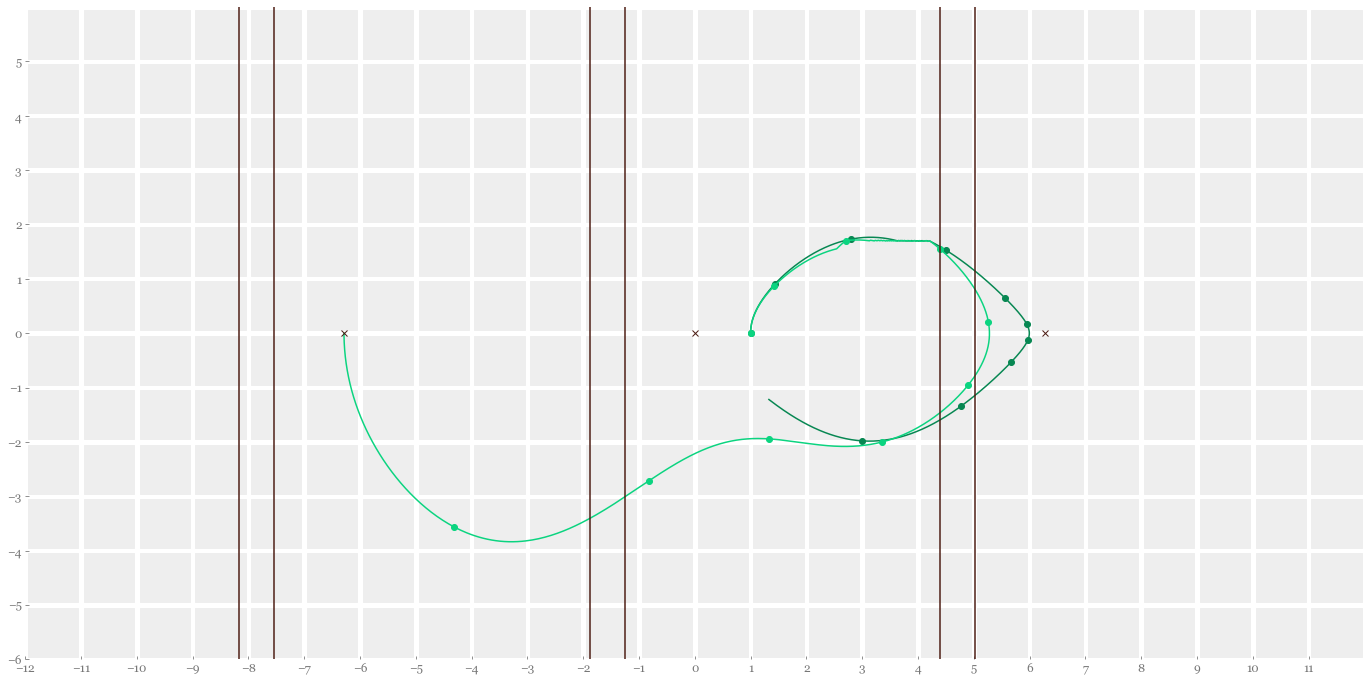

In [21]:
# Plot the resultant trajectories

# Setup the figure
fig = plt.figure(figsize=[24,12])
plt.axis([-12,12,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-12,12),range(-6,6))

dotTimes = np.arange(0,N,100)
# Plot the initialization
plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,dotTimes],
         states_init[1,dotTimes],
         'ro',color=colors[0][1])

# Plot the iterative LQR optimized trajectory
def wrapAngle(angles):
    wraplowend = -np.pi
    wraplength = 2*np.pi
    #return((angles - wraplowend) % wraplength + wraplowend)
    return(angles)
plt.plot(wrapAngle(mintervener_method_states[0,:]),mintervener_method_states[1,:],color=colors[2][1])
plt.plot(wrapAngle(mintervener_method_states[0,dotTimes]),
         mintervener_method_states[1,dotTimes],
         'ro',color=colors[2][1])

# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
plt.plot(goal_state[0]-2*np.pi,goal_state[1],'x',color=colors[1][0])
plt.plot(goal_state[0]+2*np.pi,goal_state[1],'x',color=colors[1][0])
# Plot the constraint
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-4*np.pi,angle2-4*np.pi,angle2-4*np.pi,angle1-4*np.pi,angle1-4*np.pi]),
         ys,
         color=colors[1][0])

plt.show

# Animate the Trajectory

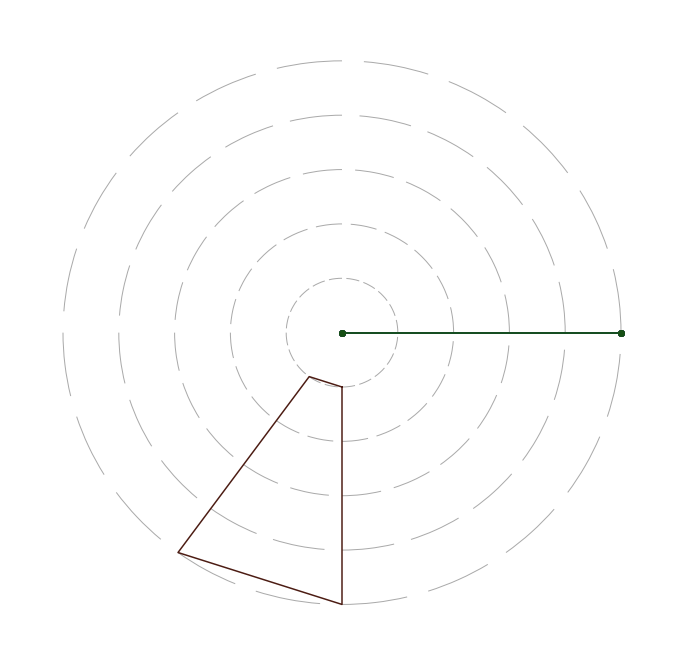

In [30]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.tick_params(direction='in')
# Set incremental tilings
angle_grid_spacing = 0.05
for rb in [1,2,3,4,5]:
    for ab in np.arange(0,1,angle_grid_spacing):
        arc = mplt.patches.Arc((0,0),2*rb,2*rb,
                                color='#AAAAAA',
                                theta1 = 360*ab,
                                theta2 = 360*(ab+0.75*angle_grid_spacing))
        ax.add_patch(arc)
# Draw the obstacle
#"""
ax.plot([1*np.sin(angle1),1*np.sin(angle2),5*np.sin(angle2),5*np.sin(angle1),1*np.sin(angle1)],
        [1*np.cos(angle1),1*np.cos(angle2),5*np.cos(angle2),5*np.cos(angle1),1*np.cos(angle1)],
        color=colors[1][0])
#"""
#ax.xaxis.label.set_color('#777777')
#ax.tick_params(axis='x', colors='#777777')
#ax.yaxis.label.set_color('#777777')
#ax.tick_params(axis='y', colors='#777777')

lines = []
for ii in range(0,6):
    line, = ax.plot([0,5], [0,0], 'o-', color=colors[1][ii])
    lines.append(line)

In [31]:
# initialization function: plot the background of each frame
def init():
    for line in lines:
        line.set_data([], [])
    return (lines)

In [32]:
# animation function. This is called sequentially
length = 5
def animate(i):
    for ii in range(0,6):
        trace = OptimizedTraces[ii]
        angle = trace[0,i]
        speed = trace[1,i]
        x = [0,length * np.sin(angle)]
        y = [0,length * np.cos(angle)]
        lines[ii].set_data(x, y)
    return (lines)

In [33]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,
                               animate, init_func=init,
                               frames=1000,
                               interval=10, blit=True)
anim

In [34]:
writervideo = animation.FFMpegWriter(fps=60) 
anim.save("export/pendulumAgent_NoPeSpeedFiveTenthsObstacle.mp4", writer=writervideo)

In [17]:
import csv
with open('export/pendulumAgent_NoObstacle.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(mintervener_method_states[0,:])
    writer.writerow(mintervener_method_states[1,:])

# Batch Production
Generate some variance with a fixed constraint set for regressing upon.

In [38]:
# Plot the resultant trajectories
ys = [-10.0,-10.0, 10.0, 10.0,-10.0]

In [97]:
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum8TenthsNopeV_reachset.json")

startingStates = [np.random.rand(2,) for ii in range(101)]
endingGoals = [np.random.rand(2,) for ii in range(101)]
for ii in range(101):
    # Scale up and re-roll the starting states
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    """
    while safeLevel.value(startingStates[ii]) < 0:
        startingStates[ii] = np.random.rand(2,)
        startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
        startingStates[ii][1] = startingStates[ii][1]*4 - 2
    """
    # Scale up and re-roll the end goals
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
    """
    while safeLevel.value(endingGoals[ii]) < 0:
        endingGoals[ii] = np.random.rand(2,)
        endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
        endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
    """

In [19]:
for ii in []:
    startingStates[ii] = np.random.rand(2,)
    endingGoals[ii] = np.random.rand(2,)
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
    print(startingStates[ii])
    print(endingGoals[ii])

[-0.85988307 -0.16661174]
[-1.81643102 -1.40251095]
[ 0.8219611  -0.43856732]
[-2.42643768 -1.13386402]


Initial cost is  [[943.67615477]]
Initialization's cost is  943.6761547747894
1 841.2612200603635
2 779.7881138714367
3 105.74844428250346
4 3.367071975729025
5 0.5266523619470842
6 0.3166089359895647
7 0.3008978535349303
8 0.29982987868177907
9 0.2985335454932452
10 0.29772839439622556
Initial cost is  [[204.67887669]]
Initialization's cost is  204.67887669007706
1 14.359329215616919
2 2.7683331482843023
3 0.7551212766051478
4 0.20048421132667407
5 0.06591875909975708
6 0.02944218363932255
7 0.02021014368955083
8 0.017685318213435643
9 0.01706590083558848
10 0.016876752558102982
Initial cost is  [[1884.27032907]]
Initialization's cost is  1884.2703290717334
1 62.47207133210284
2 18.97564692528763
3 7.780906369872567
4 5.437701987604734
5 3.08877545628093
6 2.2716957001864793
7 1.6512299635911436
8 1.382300556048259
9 1.2062652896858368
10 1.120165320973647
Lowest cost from the batch on this start-goal-pair is =====  [[0.01687675]]
Initial cost is  [[32.07964662]]
Initialization's cost

1 669.2711837617604
2 360.6821346270548
3 41.39668968174176
4 13.326691659466078
5 9.124942603057491
6 2.8901360502004727
7 2.7609653574007993
8 2.7237658968709213
9 2.7214691670034723
10 2.7113501399065796
Lowest cost from the batch on this start-goal-pair is =====  [[0.19417161]]
Initial cost is  [[206.25086733]]
Initialization's cost is  206.25086733294788
1 2.4632752820024884
2 0.06681073140233146
3 0.04955664009455657
4 0.04773495374771211
5 0.0476144325765119
6 0.04758263538065799
7 0.04755311990582404
8 0.0475171689291632
9 0.047498678844847056
10 0.04746773918627884
Initial cost is  [[877.66298977]]
Initialization's cost is  877.6629897685208
1 198.5398687353172
2 76.98260492111397
3 69.84792910873284
4 30.95612877181088
5 24.245852832463264
6 12.39215814906731
7 9.015325603944339
8 5.411623329103235
9 4.031102722919311
10 2.9134701244069587
Initial cost is  [[197.38302086]]
Initialization's cost is  197.3830208591278
1 2.1943213227591483
2 0.05951190497076897
3 0.0481617206947

3 1.0184629741785476
4 0.8236014004272515
5 0.5322792402217602
6 0.39774658042487143
7 0.27263239858685295
8 0.19893607398709456
9 0.14079782251099104
10 0.10310056461593475
Initial cost is  [[551.63311585]]
Initialization's cost is  551.6331158481559
1 414.42799482446685
2 95.60721671381619
3 50.99483301948281
4 25.8872648747693
5 12.784359961120549
6 6.479988848458574
7 3.1918929472083906
8 1.6231138642879723
9 0.8170910171694148
10 0.431601863544693
Lowest cost from the batch on this start-goal-pair is =====  [[0.10310056]]
Initial cost is  [[2728.57939704]]
Initialization's cost is  2728.5793970436303
1 122.57981433744591
2 8.764256924992385
3 2.8196229865812765
4 2.7759729613580006
5 1.5954281431602626
6 1.4328142272608693
7 1.1804547272963077
8 1.0522518837012043
9 0.9578151954198111
10 0.897110523079686
Initial cost is  [[1685.90618377]]
Initialization's cost is  1685.9061837729248
1 609.9341370211703
2 238.0949721357733
3 69.59575112517717
4 55.73900624273116
5 27.9157103023789

3 15.984966172396682
4 11.732134224626051
5 6.97144957229375
6 4.4002694521244115
7 3.3878644023038818
8 2.6992184328076343
9 2.3755713774736913
10 2.181011062039409
Initial cost is  [[206.1521944]]
Initialization's cost is  206.15219440287862
1 95.62739462201625
2 11.630355693164452
3 4.613831470293729
4 0.461106722678126
5 0.3170597945493769
6 0.25566856548851113
7 0.2530150925299274
8 0.2512800565254769
9 0.2507089559857063
10 0.2500351487650456
Initial cost is  [[319.36444682]]
Initialization's cost is  319.36444681993635
1 111.81069080765381
2 28.25646656511467
3 6.549122621262968
4 1.493052863416227
5 0.8263924723588523
6 0.5901553501842494
7 0.49496517405622664
8 0.4063344542745352
9 0.35937922027890556
10 0.3231188026772814
Lowest cost from the batch on this start-goal-pair is =====  [[0.25003515]]
Initial cost is  [[373.42862345]]
Initialization's cost is  373.4286234498656
1 1.2550503600648617
2 0.06517709776742614
3 0.05416707035642912
4 0.054142688165242814
5 0.053997448113

10 2.5053849811690805
Lowest cost from the batch on this start-goal-pair is =====  [[0.09417244]]
Initial cost is  [[282.9380627]]
Initialization's cost is  282.93806270493025
1 136.3905166348512
2 27.567584877111088
3 11.457804802260764
4 3.2271712171235354
5 1.3414130879791775
6 0.5789090211600916
7 0.3666089575796351
8 0.2909086412565649
9 0.2684854567383345
10 0.260570885263708
Initial cost is  [[197.66415115]]
Initialization's cost is  197.6641511501899
1 44.957154435375024
2 2.2727394273481396
3 0.8429931625991612
4 0.8249687486134244
5 0.8213600249840987
6 0.8168741244352524
7 0.8144565255706063
8 0.8127964062030878
9 0.8118475143816543
10 0.8110650851532258
Initial cost is  [[486.87367635]]
Initialization's cost is  486.8736763491328
1 181.40059526806894
2 83.93780281951234
3 21.294333959756187
4 11.149716152144997
5 4.700715548347368
6 3.020682492424668
7 2.204382683726479
8 1.9437462901330416
9 1.8285522029701637
10 1.7897817525113229
Lowest cost from the batch on this start-

1 3.129265645566258
2 1.8097165785466434
3 1.7890492400576212
4 1.3885557668421402
5 1.2777609291192369
6 1.1593203923150053
7 1.100367258494956
8 1.0517416938080626
9 1.0250836001158654
10 1.0044449407213771
Lowest cost from the batch on this start-goal-pair is =====  [[0.27984058]]
Initial cost is  [[548.64688468]]
Initialization's cost is  548.6468846812846
1 303.3215792676648
2 51.347930567948524
3 2.561283981977346
4 1.4145222104126585
5 1.3477453967987847
6 0.566824425283582
7 0.5575127902266594
8 0.4849931694280423
9 0.45115895666685013
10 0.42046029883176433
Initial cost is  [[325.61125204]]
Initialization's cost is  325.61125204112966
1 175.20660824741273
2 4.89897868798619
3 0.3435878456226805
4 0.1156593641474944
5 0.10062716461937621
6 0.09992925370775832
7 0.0997999413003665
8 0.09971581702325184
9 0.09959428155707487
10 0.0995079427201705
Initial cost is  [[130.4417533]]
Initialization's cost is  130.441753298888
1 119.65415111885416
2 23.11227871045206
3 1.57928285046545

1 3181.8123018843335
2 1642.4882925385575
3 86.0910966020173
4 45.979002200868806
5 8.929377904289236
6 4.527875678700444
7 2.431116113966673
8 1.7404970273443494
9 1.3284418345541247
10 1.1650855185988847
Initial cost is  [[1189.03380873]]
Initialization's cost is  1189.0338087323134
1 23.014385376803194
2 2.3494916992037695
3 1.4015141720307076
4 1.1211331751494984
5 0.9692280060106115
6 0.9039494564904847
7 0.870446218252709
8 0.8555037496726315
9 0.847890343574931
10 0.8444813846059123
Lowest cost from the batch on this start-goal-pair is =====  [[0.30149988]]
Initial cost is  [[555.08374123]]
Initialization's cost is  555.0837412288145
1 249.8393463546304
2 107.32244116423985
3 21.067111389137242
4 13.951878404398029
5 4.671301803210307
6 2.696535368807987
7 1.4937623248720924
8 1.0140900648082831
9 0.717829954496014
10 0.5838242552836923
Initial cost is  [[2648.6457095]]
Initialization's cost is  2648.6457095002124
1 121.41757181190523
2 106.6733298189186
3 0.7560064739405159
4 0

2 393.1965822978973
3 64.15731197222907
4 57.45840042772334
5 25.730822421568245
6 16.031908162063665
7 8.992798290889741
8 5.724021178883559
9 3.795165857128
10 2.81859322252388
Initial cost is  [[2399.55467855]]
Initialization's cost is  2399.5546785463166
1 2011.195079778031
2 1753.485035263614
3 192.52138485604226
4 171.5742582883612
5 34.832155586223514
6 27.15001919581311
7 7.3901616002465484
8 5.128401065134048
9 4.012427394123922
10 3.5667408367423707
Initial cost is  [[4279.95366482]]
Initialization's cost is  4279.95366481593
1 1415.1384918430238
2 509.53600407918515
3 118.50274367711704
4 80.73333924801436
5 18.45528885034976
6 12.504218804462642
7 10.944023565906281
8 8.015778541335367
9 6.721974600803521
10 5.130479168925468
Lowest cost from the batch on this start-goal-pair is =====  [[2.81859322]]
Initial cost is  [[1831.71938571]]
Initialization's cost is  1831.7193857073169
1 241.527356790147
2 200.2533921987698
3 157.07992989887472
4 110.0889915934121
5 84.21606221755

1 0.36585483454206336
2 0.0733330055750856
3 0.056966721810646714
4 0.05636088666694168
5 0.05615029997005034
6 0.05608169854873524
7 0.05588832526810947
8 0.05569421515975408
9 0.055495256829348735
10 0.05536083109472701
Initial cost is  [[20.99974159]]
Initialization's cost is  20.999741590026748
1 0.8491489970003216
2 0.046843905184433286
3 0.029808058367961562
4 0.02941267454384245
5 0.029389049416565404
6 0.029344088014577975
7 0.02931455578309446
8 0.0292724377050077
9 0.029241787601539174
10 0.02919995769157898
Initial cost is  [[44.95475343]]
Initialization's cost is  44.95475342636417
1 40.960147334896035
2 3.0601351773348884
3 0.3394293125517669
4 0.1640853228300034
5 0.15000853954937501
6 0.14919222326141396
7 0.14850686192641852
8 0.14833173002955893
9 0.14777307140984516
10 0.14708262603800268
Lowest cost from the batch on this start-goal-pair is =====  [[0.02919996]]
Initial cost is  [[790.62493497]]
Initialization's cost is  790.6249349652902
1 492.50085617769463
2 33.05

2 209.19499102876014
3 181.91062238613137
4 161.307422688712
5 77.72936588814444
6 3.786468834238899
7 3.272886589877746
8 3.1678759664710534
9 3.115930121053253
10 3.0978526476278416
Lowest cost from the batch on this start-goal-pair is =====  [[0.03173847]]
Initial cost is  [[834.73707411]]
Initialization's cost is  834.7370741123029
1 652.7149971155578
2 36.50962384301253
3 4.5690107474211565
4 3.063932766634752
5 1.72741041646584
6 1.1595963362636277
7 0.8293868703290608
8 0.6681905504870589
9 0.5859315214325469
10 0.5404507365390645
Initial cost is  [[286.87868634]]
Initialization's cost is  286.8786863392993
1 94.19075388076504
2 12.438452729203975
3 3.676263763088575
4 1.0923311691937643
5 0.44101869127033555
6 0.26567818352893685
7 0.21390762776096212
8 0.20218863359547662
9 0.19749888423945566
10 0.1967662974802394
Initial cost is  [[1614.24231936]]
Initialization's cost is  1614.2423193578834
1 1192.2863953082522
2 561.6749898087504
3 71.25125174153148
4 1.8658553736079309
5 

5 20.886950825941526
6 12.22898627921431
7 5.500635009580633
8 3.1137876875057415
9 1.6223712784824953
10 0.9973101139804543
Initial cost is  [[1452.58052539]]
Initialization's cost is  1452.5805253922913
1 360.1017533754889
2 51.25799968037278
3 16.712288135587105
4 11.561504210465367
5 7.00608915782542
6 4.703555906214939
7 3.103238118712779
8 2.303375329333624
9 1.753153535711139
10 1.4746677968905042
Lowest cost from the batch on this start-goal-pair is =====  [[0.99731011]]
Initial cost is  [[82.28632359]]
Initialization's cost is  82.2863235869689
1 4.45556501517723
2 0.4636882694725825
3 0.146184198112619
4 0.12907670312004932
5 0.12751594234252936
6 0.12732895183360743
7 0.12689446393953674
8 0.12654413946584572
9 0.12609225899262902
10 0.1258495695972358
Initial cost is  [[90.32090873]]
Initialization's cost is  90.32090872547921
1 4.845850392963261
2 0.5627798284904735
3 0.18162565053451968
4 0.15870611417508293
5 0.1563940474046749
6 0.1562416281237129
7 0.15574282323112346


6 1.6715275972780828
7 1.3324601138215961
8 1.1759963376511449
9 0.981882786037414
10 0.8662360166188354
Initial cost is  [[1883.86930731]]
Initialization's cost is  1883.8693073147656
1 269.52855889436023
2 163.78283295863224
3 30.449105514652963
4 11.18924435189108
5 6.711869056538756
6 5.096266255801201
7 3.9328903131321393
8 3.4217641850994065
9 3.112055485049796
10 2.9568180053997057
Initial cost is  [[1887.85469386]]
Initialization's cost is  1887.8546938584145
1 288.77020109540206
2 183.75565349094157
3 171.24849513433634
4 51.64288159359434
5 47.29232588009558
6 2.9698971321720427
7 2.9243984294685235
8 2.8514191611510893
9 2.8168184712653077
10 2.795546437520496
Lowest cost from the batch on this start-goal-pair is =====  [[0.86623602]]
Initial cost is  [[38.76214593]]
Initialization's cost is  38.762145928821454
1 6.385187692849911
2 0.8988433892183552
3 0.1792945043729314
4 0.047526616882941346
5 0.01815784050562374
6 0.01213137370138863
7 0.010802415219385289
8 0.0105341328

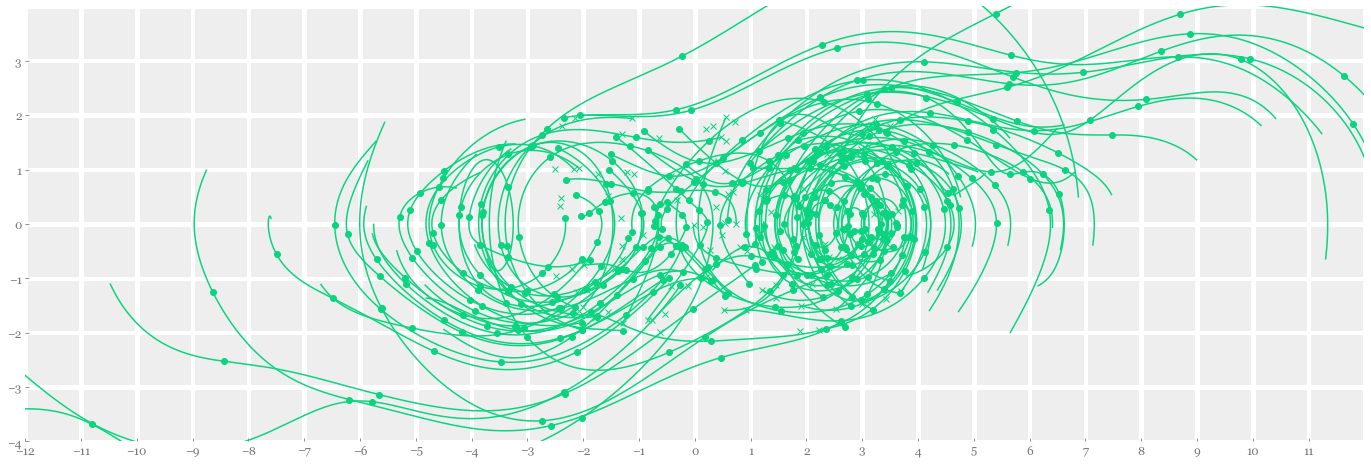

In [98]:
# Vary by randomizing start and end states

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum8TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
#safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
safe_vehicle = vehicle
timestep_length = 0.01

# Initialize the traces' memory objects
#N = 1000
N = 500
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

optimized_states = [[np.zeros((safe_vehicle.dimZ,N+1)) for jj in range(3)] for ii in range(100)]
optimized_controls = [[np.zeros((safe_vehicle.dimU,N)) for jj in range(3)] for ii in range(100)]
optimized_cost = [[0 for jj in range(3)] for ii in range(100)]

# Initialize the figure
fig = plt.figure(figsize=[24,8])
plt.axis([-12,12,-4,4])
ax = fig.axes[0]
muteAxes(ax,range(-12,12),range(-4,4))

dotTimes = np.arange(0,N,100)

OptimizedTraces = []

# Repeat optimization for multiple starting states
for ii in range(100):
    # Repeat for three runs
    lowest_jj = 0
    for jj in range(3):
        # Proscribe the terminal cost from the random goal state
        Qprox = np.diag([1,1])
        goal_state = np.copy(endingGoals[ii])
        #goal_state[1] = 0
        terminalCost = of.TerminalCost(
            WrappedFirstState(
                qof.QuadraticStateCost(
                dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                                   -2*Qprox*np.matrix(goal_state).T,
                                   np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
                )
            , 2*np.pi, goal_state[0]-np.pi)
            * 80)
        
        # Initialize a random control-trace
        cost = 999999
        while cost > 10000:
            # Forward simulate the dynamics with zero control
            startingState = np.copy(startingStates[ii])
            states_init[:,0] = startingState
            cost = 0
            #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
            constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
            for i in np.arange(0,N):
                #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
                control_init[:,i] = constant_control
                states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
                cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
            cost = cost + terminalCost.f(states_init[:,N])
            print("Initial cost is ",cost)
        
        # Optimize the trajectory
        mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                    timestep_length,
                                                                                    safe_vehicle,
                                                                                    Agent_objective,
                                                                                    terminal_cost = terminalCost * (1/timestep_length),
                                                                                    neverRetreat=True,ITER_NUM=11)
        # Save the result
        optimized_states[ii][jj] = mintervener_method_states
        optimized_controls[ii][jj] = mintervener_method_controls
        # Assess the result
        optimized_cost[ii][jj] = 0
        for i in np.arange(0,N):
            optimized_cost[ii][jj] = optimized_cost[ii][jj] + timestep_length*Agent_objective.f(mintervener_method_states[:,i],mintervener_method_controls[:,i],i)
        optimized_cost[ii][jj] = optimized_cost[ii][jj] + terminalCost.f(mintervener_method_states[:,N])
        # Find if this result is the current winner for this start-goal ii
        if optimized_cost[ii][jj] < optimized_cost[ii][lowest_jj]:
            lowest_jj = jj
    
    mintervener_method_states = optimized_states[ii][lowest_jj]
    mintervener_method_controls = optimized_controls[ii][lowest_jj]
    print("Lowest cost from the batch on this start-goal-pair is ===== ", optimized_cost[ii][lowest_jj])
    
    # Plot the iterative LQR optimized trajectory
    #thiscolor = colors[0][ii%9]
    thiscolor = colors[2][1]
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=thiscolor)
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=thiscolor)
    plt.plot(goal_state[0],goal_state[1],'x',color=thiscolor)
    OptimizedTraces.append(mintervener_method_states)

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgentShort_NoObs'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the constraint
"""
obsAngTick = 8
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
for ii in [-4,-2, 0, 2, 4]:
    plt.plot(np.array([angle1+ii*np.pi,angle2+ii*np.pi,angle2+ii*np.pi,angle1+ii*np.pi,angle1+ii*np.pi]),
             np.array(ys),
             color=colors[1][0])
"""

plt.show
plt.savefig("NoObs_TaxiDistro_Triplicate.pdf")
#plt.savefig("NoObs_TaxiDistro_15Iters.pdf")
# 0:Rust, 1:Turquoise, 2:Sand, 3:Indigo, 4:Teal, 5:Spring, 6:Flesh, 7:Magenta, 8:Gray

In [99]:
filename = 'export/pendulumAgent_startEnds_NoObs_TaxiDistro_triplicate'
with open(filename+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(range(0,100))
    writer.writerow([start[0] for start in startingStates])
    writer.writerow([start[1] for start in startingStates])
    writer.writerow([goal[0] for goal in endingGoals])
    writer.writerow([goal[1] for goal in endingGoals])

In [100]:
import json

optimized_states_listy = [[trajectory.tolist() for trajectory in batch] for batch in optimized_states]
optimized_controls_listy = [[trajectory.tolist() for trajectory in batch] for batch in optimized_controls]
optimized_costs_listy = [[trajectory.tolist() for trajectory in batch] for batch in optimized_cost]

with open(filename+'.json', 'w') as filehandle:
    json.dump({'states': optimized_states_listy,
               'controls': optimized_controls_listy,
               'costs': optimized_costs_listy
              },
              filehandle, sort_keys=True, indent=4)

# Test the Dumping Data

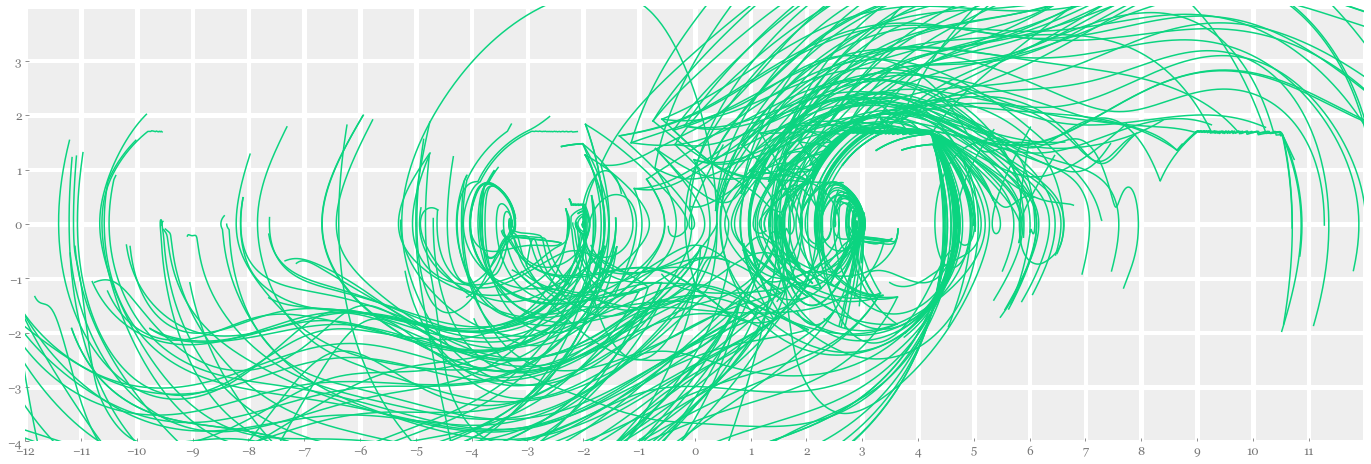

In [92]:
# Test the optimized_states object
fig = plt.figure(figsize=[24,8])
plt.axis([-12,12,-4,4])
ax = fig.axes[0]
muteAxes(ax,range(-12,12),range(-4,4))

for batch in optimized_states:
    for trajectory in batch:
        plt.plot(trajectory[0,:],trajectory[1,:],color=thiscolor)

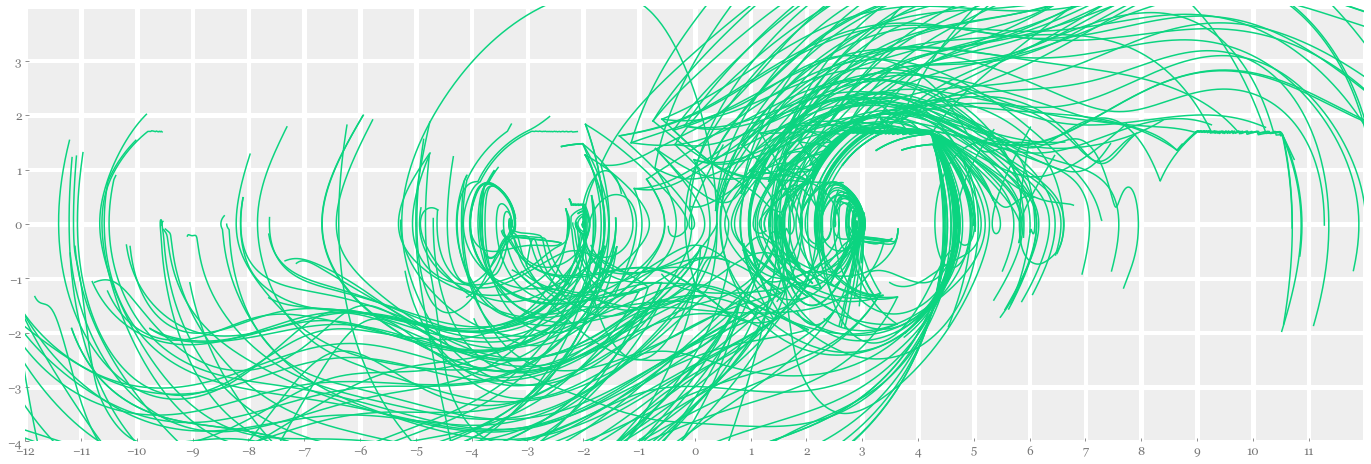

In [90]:
# Test whether it saved correctly
with open(filename+'.json', 'r') as filehandle:
    optimizedRuns = json.load(filehandle)

fig = plt.figure(figsize=[24,8])
plt.axis([-12,12,-4,4])
ax = fig.axes[0]
muteAxes(ax,range(-12,12),range(-4,4))

for batch in optimizedRuns['states']:
    for trajectory in batch:
        plt.plot(np.array(trajectory[0]),np.array(trajectory[1]),color=thiscolor)

# Batch-simulate with variance from random initial control-sequence

Initial cost is  [[178.85080649]]
Initialization's cost is  178.85080648570275
1 168.66979543671363
2 4.3653591265399045
3 0.6200990589783952
Initial cost is  [[13117.51483836]]
Initial cost is  [[199898.97713031]]
Initial cost is  [[2818.89968407]]
Initialization's cost is  2818.899684067443
1 1854.725541333636
2 1520.9435772068844
3 1402.7774722775168
Initial cost is  [[137198.24169811]]
Initial cost is  [[949.76754248]]
Initialization's cost is  949.7675424817851
1 919.029291995899
2 4.394955064838825
3 0.07144831808054786
Initial cost is  [[44853.67513755]]
Initial cost is  [[210617.95532603]]
Initial cost is  [[17215.96349563]]
Initial cost is  [[145851.96232216]]
Initial cost is  [[129344.87404193]]
Initial cost is  [[196.66697549]]
Initialization's cost is  196.66697548805905
1 5.7771076406596915
2 2.8088501597613025
3 2.643461247876948
Initial cost is  [[170499.11064434]]
Initial cost is  [[2651.39925493]]
Initialization's cost is  2651.3992549336654
1 1574.7943717955945
2 1164

1 2325.1524148611666
2 17.135789166075654
3 0.22402898308001867
Initial cost is  [[15462.26564355]]
Initial cost is  [[167850.32404338]]
Initial cost is  [[48229.6222891]]
Initial cost is  [[48912.84946671]]
Initial cost is  [[268422.49291195]]
Initial cost is  [[2689.55662444]]
Initialization's cost is  2689.5566244440797
1 2213.5257954214003
2 2064.1302865960183
3 1820.7652604729774
Initial cost is  [[153030.34520892]]
Initial cost is  [[234824.62650311]]
Initial cost is  [[81.22397506]]
Initialization's cost is  81.2239750612861
1 19.57303438283857
2 4.638384697791101
3 0.2012543306763592
Initial cost is  [[203794.64724085]]
Initial cost is  [[1839.99090733]]
Initialization's cost is  1839.990907332603
1 1185.681295002329
2 659.7082021386686
3 18.882252632813948
Initial cost is  [[2859.77360046]]
Initialization's cost is  2859.773600459722
1 2111.058044666603
2 1982.8139657104482
3 1727.1745263280734
Initial cost is  [[72021.93169853]]
Initial cost is  [[149317.75402288]]
Initial co

3 1.9800930807826742
Initial cost is  [[2821.38484764]]
Initialization's cost is  2821.384847638601
1 1907.4383918398858
2 1612.7925340185361
3 1457.8016357429467
Initial cost is  [[2826.58337411]]
Initialization's cost is  2826.5833741107367
1 2376.28880996172
2 27.753492383532482
3 0.3937154433583191
Initial cost is  [[80.95841824]]
Initialization's cost is  80.95841824186276
1 46.63046163356952
2 0.5586823583231924
3 0.0431368169308404
Initial cost is  [[78.12349402]]
Initialization's cost is  78.12349401784992
1 18.436099177010803
2 4.162989977557695
3 0.9372098026783079
Initial cost is  [[218.45289952]]
Initialization's cost is  218.45289952356816
1 64.45693505326857
2 8.051048370980627
3 0.189159228923249
Initial cost is  [[69.45848247]]
Initialization's cost is  69.4584824728983
1 13.295790865084784
2 2.6334278203029426
3 1.6751725493573777
Initial cost is  [[177.79384331]]
Initialization's cost is  177.79384330904995
1 71.56857676544502
2 5.7630400827620125
3 5.43996474206013
I

<function matplotlib.pyplot.show(close=None, block=None)>

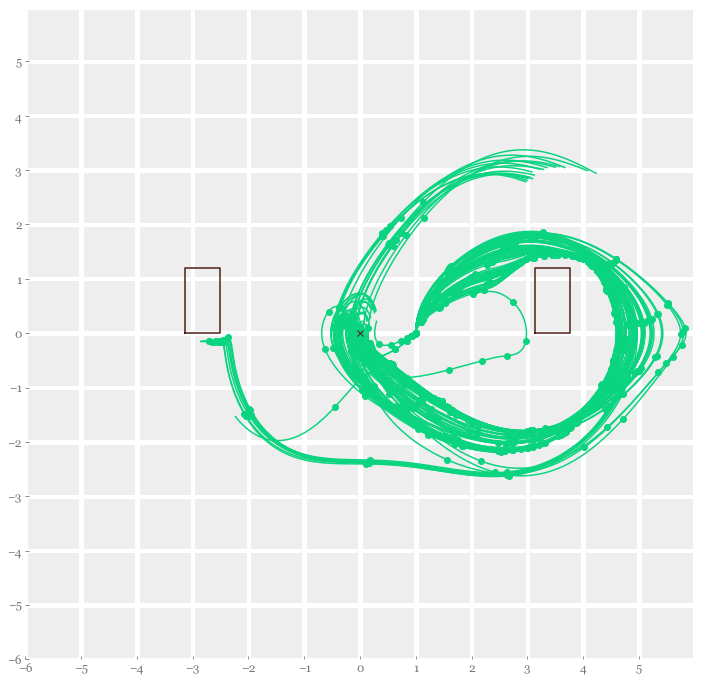

In [21]:
# Vary by randomizing initial control sequence

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Initialize the traces' memory objects
N = 1000
startingState = [1,0]
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Initialize the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

dotTimes = np.arange(0,N,100)

# Repeat optimization for multiple starting states
for ii in range(1,100):
    cost = 999999
    while cost > 10000:
        # Forward simulate the dynamics with zero control
        states_init[:,0] = startingState
        cost = 0
        #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
        constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
        for i in np.arange(0,N):
            #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
            control_init[:,i] = constant_control
            states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
            cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
        cost = cost + terminalCost.f(states_init[:,N])
        print("Initial cost is ",cost)
        
    # Optimize the trajectory
    mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                timestep_length,
                                                                                safe_vehicle,
                                                                                Agent_objective,
                                                                                terminal_cost = terminalCost * (1/timestep_length),
                                                                                neverRetreat=True,ITER_NUM=4)
    
    # Plot the iterative LQR optimized trajectory
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=colors[2][1])

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgent_5TenthsNopeVObstacleTruncated'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show